In [56]:
import re
from pathlib import Path
from typing import List

import altair as alt
import pandas as pd
import pycountry
from wbgapi import economy
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from IPython.core.display_functions import display
from IPython.display import Markdown
from datetime import datetime

In [57]:
# set the display options to allow resizing columns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [58]:
concepts_path = Path().absolute().parent / 'concepts'

In [59]:
concept = "fossil-fuels"
date_of_nb = datetime.now().strftime("%d-%m-%Y")
df_concepts = pd.read_excel(concepts_path / concept / "output_with_metadata.xlsx")
df_spans = pd.read_csv(concepts_path / concept / "spans.csv")
date_of_nb = datetime.today().strftime('%d-%m-%Y')

In [60]:
df_concepts = pd.read_excel(concepts_path / concept / "output_with_metadata.xlsx")
df_spans = pd.read_csv(concepts_path / concept / "spans.csv")

In [61]:
start_col_name = "text"
end_col_name = "document_id"
start_col = df_concepts.columns.get_loc(start_col_name)
end_col = df_concepts.columns.get_loc(end_col_name)
indicator_columns = df_concepts.columns[start_col + 1:end_col]
# Melt the DataFrame and specify the columns to keep as id_vars
df_concepts_melted = df_concepts.melt(id_vars=[col for col in df_concepts.columns if col not in indicator_columns], var_name="Concept", value_name="value")
# filter where indicators are 1
df_concepts_melted = df_concepts_melted[df_concepts_melted["value"] == 1]

In [62]:
report_text = f"""
# Explorer Report for {concept}

 This report contains summary statistics and visualisations for all identified mentions of {concept} within the Global Stocktake submissions, as of {date_of_nb}. It summarises the total number of mentions of {concept} and the number of documents these mentions come from,  broken down by Party and non-Party stakeholders. It also includes a full list of the Parties and non-Party stakeholders which mention {concept} within the Global Stocktake submissions, broken down by subtypes. A sample of the extracts where {concept} is mentioned is included below, with a link to the full set provided. The technical annex contains the methodology used to source the data for this report.
"""
display(Markdown(report_text))


# Explorer Report for fossil-fuels

 This report contains summary statistics and visualisations for all identified mentions of fossil-fuels within the Global Stocktake submissions, as of 04-04-2023. It summarises the total number of mentions of fossil-fuels and the number of documents these mentions come from,  broken down by Party and non-Party stakeholders. It also includes a full list of the Parties and non-Party stakeholders which mention fossil-fuels within the Global Stocktake submissions, broken down by subtypes. A sample of the extracts where fossil-fuels is mentioned is included below, with a link to the full set provided. The technical annex contains the methodology used to source the data for this report.


In [63]:
df_spans['processed_sentence']=df_spans['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))
df_spans['normalised_text']=df_spans['text'].str.lower()

def plot_wordcloud(df, concept, text_col="normalised_text"):
    STOPWORDS.add(concept)
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    min_font_size = 10,
                    collocations=False,
                    ).generate(' '.join(df.loc[df['type']==concept,text_col]))

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()


In [64]:
display(Markdown("# Mentions of each concept by all stakeholders".title()))
# get bar charts for each type
for concept in df_spans['type'].unique():
    df = df_spans.loc[df_spans['type']==concept]
    df = df.groupby('id').count().reset_index()
    df = df.sort_values('text', ascending=False)
    chart = alt.Chart(df).mark_bar().encode(
        x=alt.X('text', title='Number of mentions'),
        y=alt.Y('id', title='Party or non-Party stakeholder', sort='-x'),
        tooltip=['text']
    ).properties(
        title=f"Number of mentions of {concept} related concepts by all stakeholders".title()
    )
    display(chart)

# Mentions Of Each Concept By All Stakeholders

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [65]:
def find_country(text: str) -> str:
    """
    Given a text string, attempts to find the name of a country
    mentioned in the text. Returns the name of the country if found,
    or None otherwise.
    """
    # Check for uppercase and lowercase country name
    for country in pycountry.countries:
        if country.name.upper() in text.upper():
            return country.name
        elif country.name.lower() in text.lower():
            return country.name

    # Check for common name
    for country in pycountry.countries:
        if country.name in text:
            return country.name
        if hasattr(country, 'common_name') and country.common_name in text:
            return country.common_name

        # Check for official name
        if hasattr(country, 'official_name') and country.official_name in text:
            return country.official_name

        # Check for alpha_2 code (e.g., "US" for United States)
        if country.alpha_2 in re.findall(r'\b[A-Z]{2}\b', text):
            return country.name

        # Check for alpha_3 code (e.g., "USA" for United States)
        if country.alpha_3 in re.findall(r'\b[A-Z]{3}\b', text):
            return country.name

    return None


def get_country_code(x: str) -> str:
    """
    Given the name of a country, returns its ISO 3166-1 alpha-3
    code. Returns None if the country is not found.
    """
    try:
        return pycountry.countries.get(name=x).alpha_3
    except (AttributeError, LookupError):
        return None


# Create a new column 'country' with the found country names
df_concepts_melted["document_name_x_reformatted"] = df_concepts_melted["document_name_x"].str.replace(r'[_20]+', ' ', regex=True)
df_concepts_melted["document_name_y_reformatted"] = df_concepts_melted["document_name_y"].str.replace(r'[_20]+', ' ', regex=True)
df_concepts_melted['country_x'] = df_concepts_melted['document_name_x_reformatted'].apply(find_country)
df_concepts_melted['country_y'] = df_concepts_melted['document_name_y_reformatted'].apply(find_country)
df_concepts_melted['country'] = df_concepts_melted['country_x'].combine_first(df_concepts_melted['country_y'])
# create 3 letter country code
df_concepts_melted['country_code'] = df_concepts_melted['country'].apply(get_country_code)
# create 3 letter country code
df_concepts_melted['country_code'] = df_concepts_melted['country'].apply(get_country_code)
df_eco = pd.DataFrame(economy.list())
# Assuming the 3-letter country code column in df_concepts_melted is named 'country_code'
df_concepts_melted = pd.merge(df_concepts_melted, df_eco[['id', 'region']], left_on='country_code', right_on='id', how='left')


In [66]:
def create_docs_table(df_concepts):

    # First, create a new column that categorizes each row as 'Party' or 'Non-party'
    df_concepts['category'] = np.where(df_concepts['party'].notna(), 'Party', 'Non-party')

    # Use groupby to count the unique document_id's for each category and for the total dataset
    docs_analysed = df_concepts.groupby('category')['document_id'].nunique()
    docs_analysed.loc['Total'] = df_concepts['document_id'].nunique()

    # Convert the resulting Series into a DataFrame with a single row and a custom index
    docs_analysed_table = pd.DataFrame(docs_analysed.values.reshape(1, -1),
                                       columns=docs_analysed.index,
                                       index=["Documents"])

    return docs_analysed_table
docs_analysed_table = create_docs_table(df_concepts_melted)

display(Markdown(f"# Documents analysed by category on {datetime.today().strftime('%d %B %Y')}\n"))

docs_analysed_table = docs_analysed_table.reset_index().melt(id_vars=["index"], var_name="category", value_name="count")
chart = alt.Chart(docs_analysed_table).mark_bar().encode(
x='category:N',
y='count:Q',
color='category:N'
).properties(title=f"Documents analysed by category on {datetime.today().strftime('%d %B %Y')}", width=400, height=300)
display(docs_analysed_table)
chart

# Documents analysed by category on 04 April 2023


,index,category,count
0,Documents,Non-party,173
1,Documents,Party,305
2,Documents,Total,478


alt.Chart(...)

In [67]:
df_documents=df_concepts_melted.groupby(['Concept', 'category'])['document_id'].nunique().reset_index().pivot(index='Concept', columns='category', values='document_id')
df_documents.columns.name = None

In [68]:
df_mentions = df_concepts_melted.groupby('Concept')['category'].value_counts().rename('count').reset_index().pivot(index='Concept', columns='category', values='count')#.reset_index()
df_mentions.columns.name = None

In [69]:
# Display the resulting DataFrames
display(Markdown(f"## Number of documents mentioning each concept split by party and non party stakeholders\n"))
display(df_documents)

# plot bar chart
chart = alt.Chart(df_documents.reset_index()).mark_bar().encode(
x=alt.X('Concept', title='Concept', sort='-y'),
y=alt.Y('Non-party', title='Number of documents'),
tooltip=['Non-party']
).properties(
title=f"Number of documents mentioning each concept".title()
)
display(chart)
display(Markdown(f"## Total number of mentions of each concept\n"))

# plot bar chart
chart = alt.Chart(df_mentions.reset_index()).mark_bar().encode(
x=alt.X('Concept', title='Concept', sort='-y'),
y=alt.Y('Non-party', title='Number of mentions'),
tooltip=['Non-party']
).properties(
title=f"Number of times each concept is mentioned".title()
)
display(df_mentions)
display(chart)

## Number of documents mentioning each concept split by party and non party stakeholders


,Non-party,Party
Concept,,
Coal,114,218
Fossil fuel,20,99
Gas,111,267
Oil,114,289


alt.Chart(...)

## Total number of mentions of each concept


,Non-party,Party
Concept,,
Coal,670,2715
Fossil fuel,106,280
Gas,1012,3675
Oil,1273,6108


alt.Chart(...)

In [70]:
# Get the unique concepts
concepts = df_concepts_melted.Concept.unique()

# Create a list to store the charts
charts = []

# Loop over the concepts and create a chart for each one
for concept in concepts:
    # Select the data for the current concept
    data = df_concepts_melted[df_concepts_melted['Concept'] == concept]


    # Get the top 8 counts by type and create a horizontal bar chart
    chart = alt.Chart(data['type'].value_counts().reset_index().iloc[:8]).mark_bar().encode(
        x='type:O',
        y='index:O',
        color=alt.Color('type', legend=None),
        tooltip=['type'],
    ).properties(
        title=concept
    )

    # Add the chart to the list
    charts.append(chart)
# Combine the charts using the vconcat method
combined_charts = alt.vconcat(*charts, spacing=40)

# Show the combined charts
combined_charts

alt.VConcatChart(...)

In [71]:
# group melted df by country_code and Concept and number of concept
dd=df_concepts_melted.groupby(['country_code', 'Concept'])['Concept'].count().rename('count').reset_index()
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
merged = world.set_index("iso_a3").join(dd.set_index("country_code"), how="inner")

# Geographical distribution of concepts

In [72]:
# Function to create a choropleth map for a given concept
def create_choropleth_map(merged, concept):
    choropleth_map = (
        alt.Chart(merged[merged['Concept'] == concept])
        .mark_geoshape(stroke="black", strokeWidth=1)
        .encode(
            color=alt.Color("count:Q", scale=alt.Scale(scheme="viridis")),
            tooltip=["continent:N", "count:Q"],
        )
        .properties(width=800, height=400, title=f"Number of Mentions of {concept} by Country")
    )
    return choropleth_map

# Iterate over the unique concepts and create a separate choropleth map for each
unique_concepts = sorted(merged['Concept'].unique())
for concept in unique_concepts:
    choropleth_map = create_choropleth_map(merged, concept)
    choropleth_map.display()

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

# Sample mentions of concepts

Here is a sample of mentions of concepts in the documents. To see the full list, see here (TODO: add link to external Excel download).

In [73]:
# get a unique mapping between document_id and document_name_y for the df_concepts_melted
mapping = df_concepts_melted[['document_id', 'document_name_y', 'category']].drop_duplicates()
# now apply this mapping to df_spans to create a new column with the document_name
df_spans = df_spans.merge(mapping, on=['document_id'], how='left')

In [83]:
df_spans_sample = df_spans[['document_name_y', 'type','category', 'sentence']].dropna().sample(10)
# display the dataframe. If any of the columns are too long, expand the row to show the full text
display(df_spans_sample.style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')])]))
# display(df_spans_sample)
# # give a nice display of the sample
# for i, row in df_spans_sample.iterrows():
#     display(Markdown(
#                      f"\nDocument name: {row['document_name_y']}"
#                      f"\nCategory: {row['type']}"
#                      f"\nParty or non-party?: {row['category']}"
#                      f"\nText: {row['sentence']}\n"))

,document_name_y,type,category,sentence
24190,Liechtenstein. Biennial Reports (BR). BR 3. National Communication (NC). NC 7.,OIL,Party,The levy on fossil fuel consumption covers all the sectors of economy (except motor fuels such as petrol and diesel) as well as private households and is intended to promote the economical use of fossil fuels throughout Liechtenstein.
11389,Nigeria. Biennial update report (BUR). BUR2.,OIL,Party,The coastal environment houses the oil and gas industry of Nigeria.
18058,Cambodia. National Communication (NC). NC 2.,GAS,Party,"Based on methodologies set by IPCC-GPG, the methane emission from rice production is estimated by multiplying the disaggregated harvested area by the appropriate emission factor under different ecosystems, water management regimes, soil and other conditions under which CH4 will be affected."
16004,Solomon Islands. National Communication (NC). NC 2.,GAS,Party,"A few factories are treating their waste waters and pipe them into the sewage pipeline, hence it is assumed that GHGS especially methane is emitted directly into the atmosphere."
1212,Rwanda. Biennial update report (BUR). BUR 1.,OIL,Non-party,"The petroleum products consumed in the Energy sector in Rwanda include diesel/gas oil, heavy fuels oil, kerosene, motor gasoline, liquid petroleum gas, etc."
22764,United States of America. Biennial report (BR). BR 2.,GAS,Party,"human-related methane emissions, accounting for 18 percent of methane emissions in 2013- or approximately 100 Mt CO₂e."
7923,Jamaica. Biennial update report (BUR). BUR 1.,GAS,Non-party,Section 6.2.3.2 of the 2006 IPCC Guidelines suggested the default value of 0.25 for the maximum methane producing capacity (B₂).
24623,Republic of Moldova. Biennial update report (BUR). BUR 3. National inventory report.,OIL,Non-party,"There are also a series of activity data associated with aviation gasoline consumption for the years 2011-2019, provided by the Civil Aeronautical Authority of the Republic of Moldova."
25926,India. National Communication (NC). NC 2.,OIL,Party,"In case of handling and distribution of oil and natural gas, the release of gas occurs through leakages in pipelines, due"
23377,Technical analysis of the second biennial update report of Tunisia submitted on 31 December 2016. Summary report by the team of technical experts,GAS,Party,"The GHG emissions reported for 2012 include 36,567.7 kt CO2, 7,145 kt CO₂ eq methane (CH₂) and 2,567.2 kt CO₂ eq nitrous oxide (N₂O) (excluding AFOLU)."


# Other Visualisations (Suggestions?)

# Wordclouds of concepts to indicate commonality of related words


## Common words in sentences relating to Gas


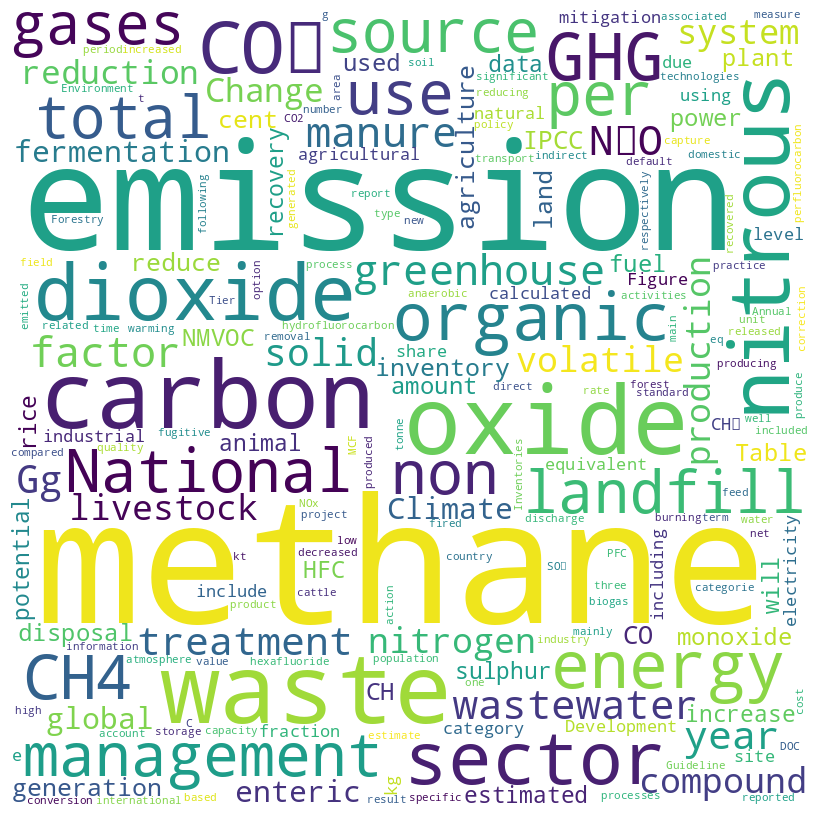

## Common words in sentences relating to Oil


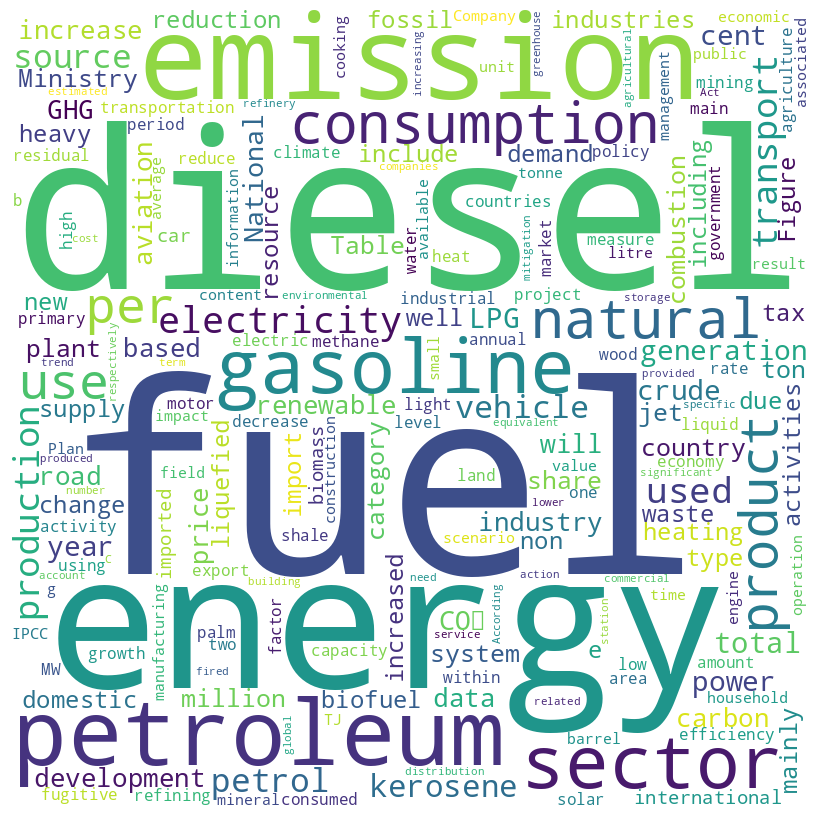

## Common words in sentences relating to Coal


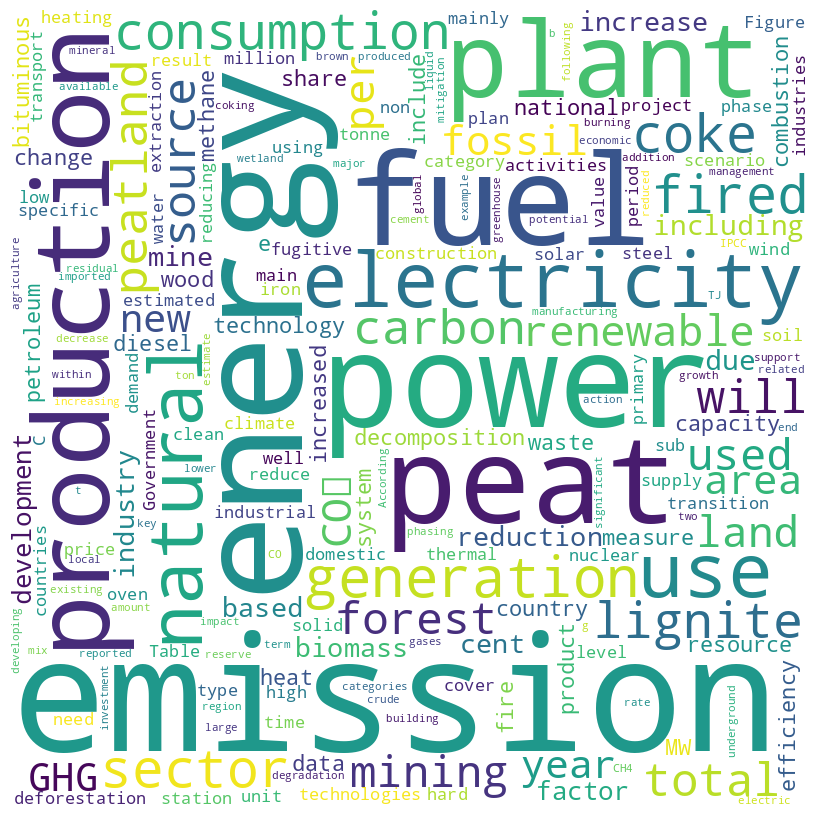

## Common words in sentences relating to Fossil_Fuel


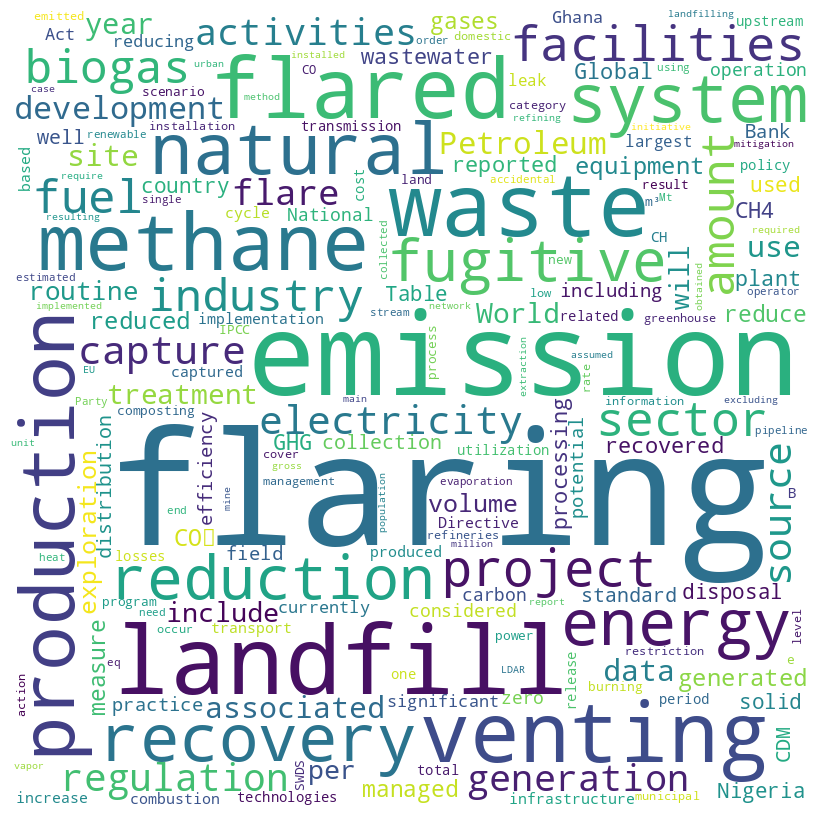

In [75]:
display(Markdown(f"# Wordclouds of concepts to indicate commonality of related words\n"))
concepts = df_spans.type.unique()
# plot wordclouds for each concept with a markdown header
for concept in concepts:
    display(Markdown(f"## Common words in sentences relating to {concept.title()}\n"))
    plot_wordcloud(df_spans, concept, text_col="processed_sentence")


In [76]:
import warnings

warnings.filterwarnings("ignore")

infile=pd.read_excel("/home/stefan/PycharmProjects/global-stocktake/concepts/fossil-fuels/input.xlsx", header=[0,1]);

In [77]:
excel_string = infile.to_csv(sep='\t', index=False, header=False)

In [78]:
#, header=[0,1])
# infile.columns = infile.columns.map(' - '.join)
infile.columns = [' - '.join(col).strip() if 'Unnamed' not in col[1] else col[0] for col in infile.columns]

In [79]:
display(Markdown(f"""# Annex: Methodology
The documents within the Global Submissions Information Portal were searched for all mentions of {concept}. The documents are all automatically translated into English using a Google Translate API, and the full text of all documents are then searched and return mentions of {concept} within the translated or original text.

To capture the variations of the expression of {concept} within the Global Stocktake submissions, the following input file was created."""))

display(infile)


display(Markdown(F"""The root forms of the terms were used so that all variations of these listed terms were searched. For example, ‘technology’ would return ‘technologies’ and ‘technological’.

Terms connected with a hyphen are also returned separately. For example, ‘coal-fired’ would return ‘coal-fired’ and ‘coal fired’."""))


# Annex: Methodology
The documents within the Global Submissions Information Portal were searched for all mentions of FOSSIL_FUEL. The documents are all automatically translated into English using a Google Translate API, and the full text of all documents are then searched and return mentions of FOSSIL_FUEL within the translated or original text.

To capture the variations of the expression of FOSSIL_FUEL within the Global Stocktake submissions, the following input file was created.

,Pattern name (optional),Span label,Pattern description,Span ID (optional),Token 1 - Rule type 1,Token 1 - Value 1,Token 1 - Rule type 2,Token 1 - Value 2,Token 2 - Rule type 1,Token 2 - Value 1,Token 2 - Rule type 2,Token 2 - Value 2,Token 3 - Rule type 1,Token 3 - Value 1,Token 3 - Rule type 2,Token 3 - Value 2,Token 4 - Rule type 1,Token 4 - Value 1,Token 4 - Rule type 2,Token 4 - Value 2,Token 5 - Rule type 1,Token 5 - Value 1,Token 5 - Rule type 2,Token 5 - Value 2,Token 6 - Rule type 1,Token 6 - Value 1,Token 6 - Rule type 2,Token 6 - Value 2,Token 7 - Rule type 1,Token 7 - Value 1,Token 7 - Rule type 2,Token 7 - Value 2,Token 8 - Rule type 1,Token 8 - Value 1,Token 8 - Rule type 2,Token 8 - Value 2
0,FOSSIL_FUELS,Oil,NaN,oil,LOWER,oil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Oil,NaN,oil,LOWER,petroleum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Oil,NaN,gasoline,LOWER,gasoline,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Oil,NaN,gasoline,LOWER,petrol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Oil,NaN,kerosene,LOWER,kerosene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,Oil,NaN,diesel,LOWER,diesel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,Oil,NaN,aviation fuel,LOWER,jet,NaN,NaN,LOWER,fuel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,Oil,NaN,aviation fuel,LOWER,aviation,NaN,NaN,LOWER,fuel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,Oil,NaN,fracking,LOWER,fracking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,Oil,NaN,fracking,LOWER,hydraulic,NaN,NaN,LOWER,fracturing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The root forms of the terms were used so that all variations of these listed terms were searched. For example, ‘technology’ would return ‘technologies’ and ‘technological’.

Terms connected with a hyphen are also returned separately. For example, ‘coal-fired’ would return ‘coal-fired’ and ‘coal fired’.

In [80]:
# Note: you need to be using OpenAI Python v0.27.0 for the code below to work
import openai

def explain_excel_content(prompt):
    response = openai.Completion.create(
    model="text-davinci-003",
    prompt=prompt,
    temperature=0.0,
    max_tokens=150,
    )
    return response.choices[0].text.strip()

# Describe the content of the Excel file
# Replace this description with the actual content or structure of your Excel file
excel_file = infile


# Generate a prompt for the OpenAI API
prompt = f"Please provide a short intuitive explanation of the spacy linguistic rules in this copy and paste from a excel file. Assume the user doesn't have any linguistic knowledge: {excel_string}"

# Send the request to the OpenAI API
explanation = explain_excel_content(prompt)

# Explanation of the linguistic rules using OpenAI? (WIP - Haven't used GPT-4 or experimented with prompt much)

Note, I'm thinking we send a request to GPT-4 to generate a short and intuitive explanation of what's in the Excel file as the linguistic rules are opaque to anyone not familiar with Spacy or at the very least linguistic concepts. Below is a very simple stab at this, but it is not that good as it's relying on davinci-003 and not GPT-4 (couldn't get request working). But results look good when accessing GPT-4 via chat GPT in browser, so could be helpful for generating tldr of the linguistic rules if this is painful to spell out based on the file?



In [81]:
display(explanation)

'The spacy linguistic rules in this excel file are used to identify different types of fossil fuels. For example, the rules state that "oil" should be identified as "oil", "petroleum", "gasoline", "petrol", "kerosene", "diesel", "jet fuel", "aviation fuel", "fracking", "oil-fired", "tar sands", "offshore well", "offshore rig", "offshore platform", "LNG", "LPG", "GLP", "gas-fired", "methane", "coal", "anthracite", "bituminous", "sub-bituminous", "lignite", "peat", "peatlands", "'